In [ ]:
import rawpy
import numpy as np
from PIL import Image

def preview_and_compare_img(
    original_img: np.ndarray,
    applied_styled_img: np.ndarray = None,
    width: int = 600,
    convert_bgr_to_rgb: bool = True
) -> Image.Image:
    """
    Preview a np.ndarray image, optionally comparing it side-by-side with a styled image.

    Parameters:
        original_img (np.ndarray): Input image (BGR or RGB depending on convert_bgr_to_rgb).
        applied_styled_img (np.ndarray, optional): Styled RGB image to compare.
        width (int): Resize width for display (height scaled proportionally).
        convert_bgr_to_rgb (bool): Whether to convert images from BGR to RGB before rendering.

    Returns:
        PIL.Image.Image: Single image (if no comparison) or side-by-side comparison.
    """

    def resize_np_image(img_np, target_width):
        if convert_bgr_to_rgb:
            img_np = img_np[..., ::-1]  # BGR to RGB
        h, w = img_np.shape[:2]
        scale = target_width / w
        new_size = (target_width, int(h * scale))
        return Image.fromarray(img_np).resize(new_size)

    img1_resized = resize_np_image(original_img, width)

    if applied_styled_img is None:
        return img1_resized

    styled_resized = resize_np_image(applied_styled_img, width)

    combined = Image.new("RGB", (img1_resized.width + styled_resized.width,
                                 max(img1_resized.height, styled_resized.height)))
    combined.paste(img1_resized, (0, 0))
    combined.paste(styled_resized, (img1_resized.width, 0))

    return combined


In [2]:
import cv2
import numpy as np
from typing import Tuple

def align_images_by_features(img1: np.ndarray, img2: np.ndarray, scale: float = 0.5) -> Tuple[np.ndarray, np.ndarray]:
    """
    Align img2 to img1 using ORB feature detection and homography transformation.

    Parameters:
        img1 (np.ndarray): Reference image (RGB).
        img2 (np.ndarray): Image to be aligned (RGB).
        scale (float): Downscaling factor for faster computation (default 0.5).

    Returns:
        Tuple[np.ndarray, np.ndarray]: (img1, img2_aligned) where img2_aligned matches the perspective of img1.
    """
    h, w = img1.shape[:2]

    # Resize images for faster feature detection
    img1_small = cv2.resize(img1, (int(w * scale), int(h * scale)))
    img2_small = cv2.resize(img2, (int(w * scale), int(h * scale)))

    # Convert to grayscale for feature detection
    gray1 = cv2.cvtColor(img1_small, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2_small, cv2.COLOR_RGB2GRAY)

    # ORB feature detector
    orb = cv2.ORB_create(nfeatures=5000)
    kp1, des1 = orb.detectAndCompute(gray1, None)
    kp2, des2 = orb.detectAndCompute(gray2, None)

    # Match features using Brute Force Hamming matcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Ensure sufficient matches found
    if len(matches) < 10:
        raise ValueError("Not enough matches found for alignment.")

    # Extract matched keypoints and rescale back
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2) / scale
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2) / scale

    # Compute homography matrix
    H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

    # Warp img2 to align with img1
    img2_aligned = cv2.warpPerspective(img2, H, (w, h))

    return img1, img2_aligned


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

def visualize_feature_matches(
    img1: np.ndarray,
    img2: np.ndarray,
    scale: float = 0.5,
    max_matches: int = 50
) -> np.ndarray:
    """
    Visualize the feature matches between two RGB images using ORB and Brute-Force matcher.

    Parameters:
        img1 (np.ndarray): First input image (reference).
        img2 (np.ndarray): Second input image (to compare).
        scale (float): Downscale factor for faster feature extraction (default is 0.5).
        max_matches (int): Maximum number of matches to draw.

    Returns:
        np.ndarray: RGB image showing matches with lines connecting matching features.
    """
    # Resize images for faster matching
    img1_small = cv2.resize(img1, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
    img2_small = cv2.resize(img2, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)

    # Convert to grayscale for ORB
    gray1 = cv2.cvtColor(img1_small, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2_small, cv2.COLOR_RGB2GRAY)

    # Detect ORB keypoints and descriptors
    orb = cv2.ORB_create(nfeatures=2000)
    kp1, des1 = orb.detectAndCompute(gray1, None)
    kp2, des2 = orb.detectAndCompute(gray2, None)

    # Match descriptors using brute-force Hamming matcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)[:max_matches]

    # Rescale keypoint positions to original image dimensions
    kp1_full = [cv2.KeyPoint(pt.pt[0] / scale, pt.pt[1] / scale, pt.size) for pt in kp1]
    kp2_full = [cv2.KeyPoint(pt.pt[0] / scale, pt.pt[1] / scale, pt.size) for pt in kp2]

    # Draw the matches
    match_img = cv2.drawMatches(
        img1, kp1_full, img2, kp2_full, matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # Convert to RGB if needed (OpenCV draws in BGR by default)
    return cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB)


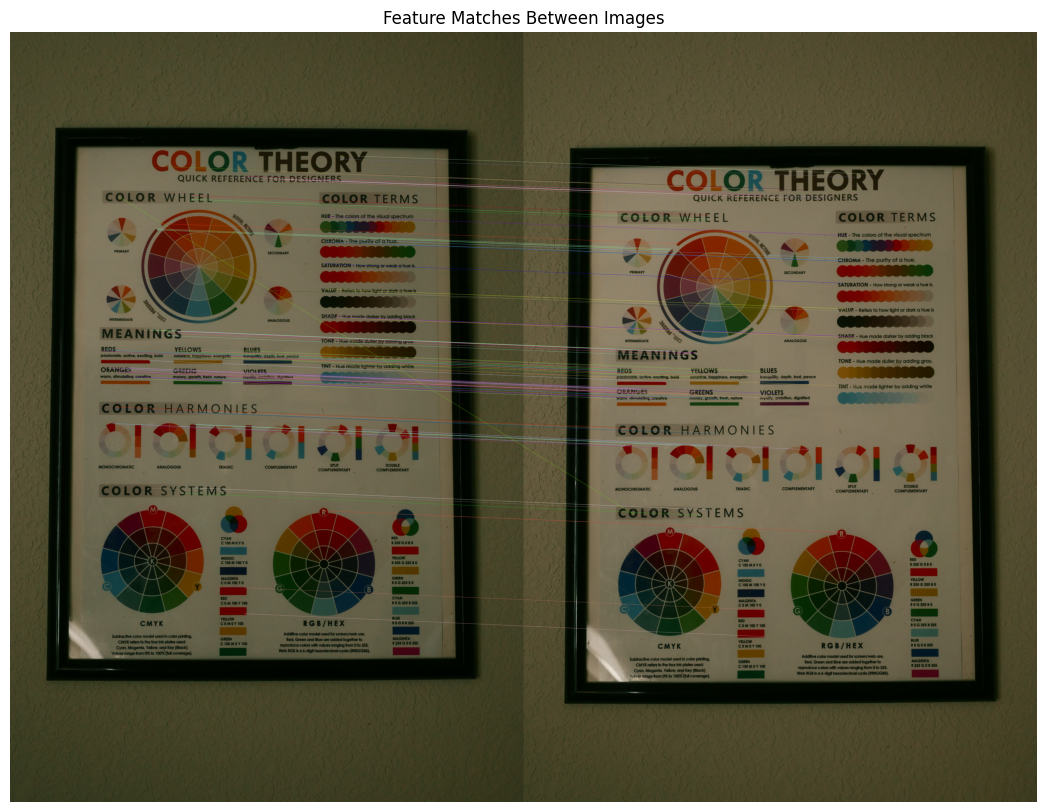

In [4]:
# Load the previously uploaded images
img1_path = "input/DSC_8783.JPG"
img2_path = "input/DSC_8784.JPG"

# Load and convert to RGB
img1 = cv2.cvtColor(cv2.imread(img1_path), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(img2_path), cv2.COLOR_BGR2RGB)

img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

match_vis = visualize_feature_matches(img1_rgb, img2_rgb, scale=0.5, max_matches=100)

plt.figure(figsize=(16, 10))
plt.imshow(match_vis)
plt.title("Feature Matches Between Images")
plt.axis('off')
plt.show()


In [5]:
import cv2
import numpy as np
from typing import Tuple

def crop_to_shared_region(img1: np.ndarray, img2: np.ndarray, threshold: int = 10) -> Tuple[np.ndarray, np.ndarray]:
    """
    Conservatively crops two aligned images to their mutually overlapping non-black region.

    Parameters:
        img1 (np.ndarray): First RGB image.
        img2 (np.ndarray): Second RGB image aligned to img1.
        threshold (int): Pixel intensity threshold to consider a pixel as valid (non-black).

    Returns:
        Tuple[np.ndarray, np.ndarray]: Cropped img1 and img2 to the shared content region.
    """
    assert img1.shape == img2.shape, "Images must have the same shape"

    # Create masks of non-black regions in both images
    mask1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY) > threshold
    mask2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY) > threshold
    shared_mask = mask1 & mask2

    # Find bounding box of the shared mask
    coords = np.argwhere(shared_mask)
    if coords.size == 0:
        raise ValueError("No shared region found between the two images.")

    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    # Crop images using the shared bounding box
    cropped_img1 = img1[y_min:y_max + 1, x_min:x_max + 1]
    cropped_img2 = img2[y_min:y_max + 1, x_min:x_max + 1]

    return cropped_img1, cropped_img2


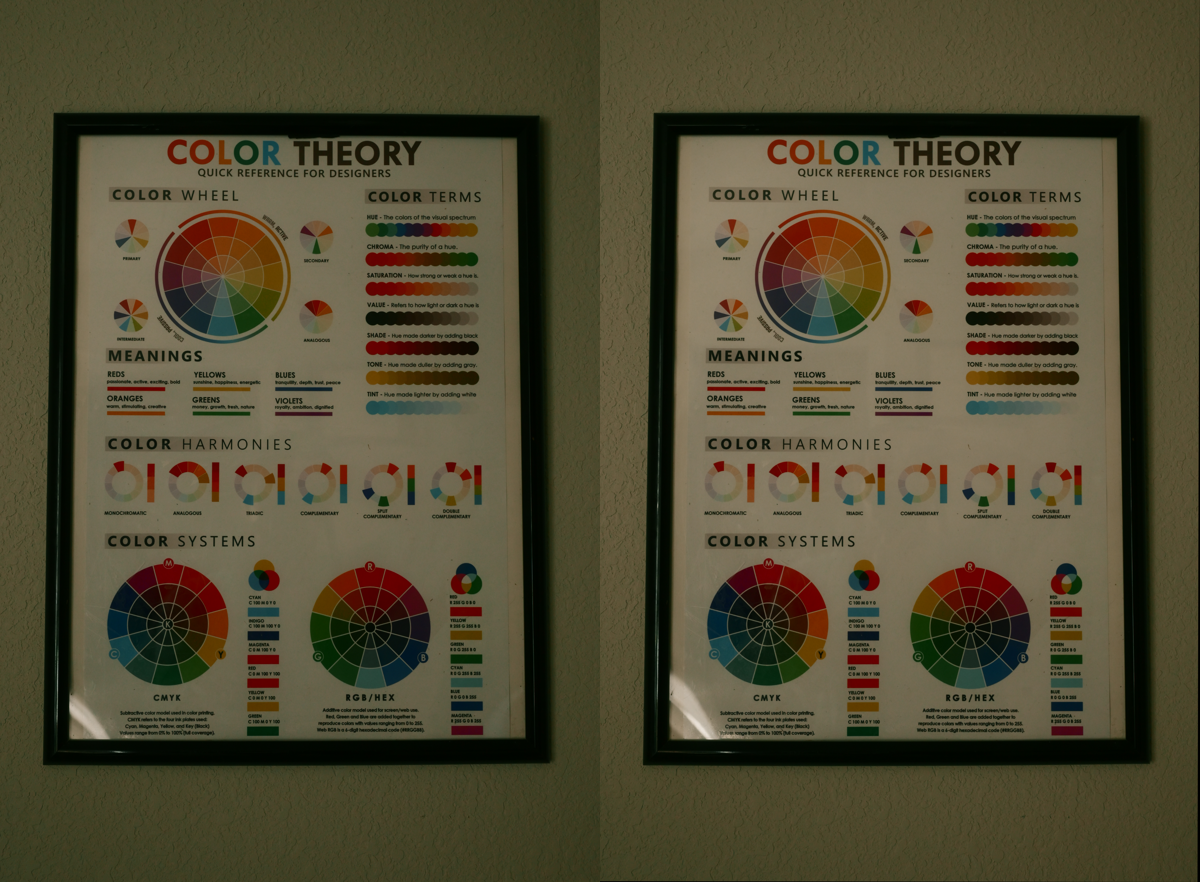

In [6]:
# Load the previously uploaded images
img1_path = "input/DSC_8783.JPG"
img2_path = "input/DSC_8784.JPG"

# Load and convert to RGB
img1 = cv2.cvtColor(cv2.imread(img1_path), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(img2_path), cv2.COLOR_BGR2RGB)

aligned_img1, aligned_img2 = align_images_by_features(img1, img2)
cropped1, cropped2 = crop_to_shared_region(aligned_img1, aligned_img2)

preview_and_compare_img(cropped1, cropped2).show()

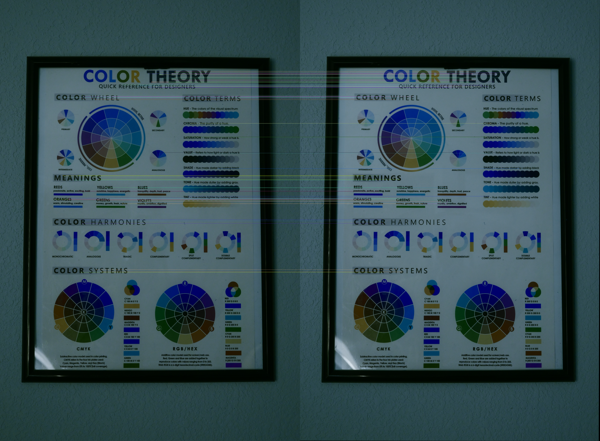

In [7]:
# Load the previously uploaded images
img1_path = "input/DSC_8783.JPG"
img2_path = "input/DSC_8784.JPG"

# Load and convert to RGB
img1 = cv2.cvtColor(cv2.imread(img1_path), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(img2_path), cv2.COLOR_BGR2RGB)

aligned_img1, aligned_img2 = align_images_by_features(img1, img2)
cropped1, cropped2 = crop_to_shared_region(aligned_img1, aligned_img2)

match_vis = visualize_feature_matches(cropped1, cropped2, scale=0.5, max_matches=100)

preview_and_compare_img(match_vis)
